# INF 420 - Trabalho Final

Leonardo de Andrade Porto - 112681

Marianna Drago Verduin - 112697

## Problema

Nesse trabalho, o objetivo é testar diversas técnicas de inteligência artifical para classificar imagens de itens de supermercado. O dataset usado é o [Freibug Groceries Dataset](https://github.com/PhilJd/freiburg_groceries_dataset), que tem 5000 imagens RGB de 256x256 distribuidas em 25 classes.

## Variáveis do código geral

In [4]:
dataset_path = "images/"  # Diretório das imagens do dataset (se rodar no colab, trocar para content/images/)
model_path = "best_model_acc_0.9031.pth" # Path para o modelo que quiser carregar (rode a célula de carregar modelo). Mude para None se quiser que não carregue nenhum modelo

seed = 7 # Seed para fixar aleatoriedade (numpy, pytorch e gerador)

batch_size = 64 # Número de tensores carregados por vez (16 rodou na cpu, até 64 rodou na gpu, se colocar mais, o vs pode crashar)
train_percentage = 0.7 # % de dados pro treino
test_percentage = 0.15 # % de dados pra teste
val_percentage = 1-train_percentage-test_percentage # % de dados para validação

num_workers = 4 # Relativo a paralelismo, quanto maior, mais da cpu pode ser usado

saving_path = "checkpoints/"

## Instalando e Importando Bibliotecas

In [3]:
%pip install torchvision numpy pillow scipy tqdm scikit-learn matplotlib
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://download.pytorch.org/whl/cu121
Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import torchvision.models as models
from torchvision.datasets import ImageFolder
import torchvision
from torchvision.transforms.functional import to_pil_image
import torch.nn as nn
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt
from PIL import Image
import os
from subprocess import call
from urllib.request import urlretrieve
import numpy as np
import os
from copy import deepcopy
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score
import torchvision.transforms as transforms
import torch.optim as optim
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
from torch.utils.data import Subset
from typing import List, Dict, Any
import random
from datetime import datetime

## Criação, e treinamento da CNN

### Parâmetros e hiper-parâmetros da CNN 

In [5]:
torch.manual_seed(seed)
generator = torch.Generator().manual_seed(seed) 
np.random.seed(seed)

# Parâmetros fixos
num_classes = 25

# Parâmetros mutáveis pelo programador
epochs = 150
learning_rate = 0.001 # Pequeno pois tem fine tuning

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Se roda na GPU ou CPU (está verificando automaticamente)
print(f"Usando {device}")

# Só usa pin memory com GPU 
pin_memory = True if device.type == 'cuda' else False

now = datetime.now()
curr_time = now.strftime("%Y-%m-%d_%H-%M-%S")

Usando cuda


### Baixando o dataset

In [7]:
def download_freiburg() -> None: 
    """
    Instala o dataset Freiburg Groceries
    """

    dataset_url = "http://aisdatasets.informatik.uni-freiburg.de/freiburg_groceries_dataset/freiburg_groceries_dataset.tar.gz"
    download_path = "freiburg_groceries_dataset.tar.gz"
    extract_path = "freiburg_groceries_dataset"
    print("Downloading dataset.")
    urlretrieve(dataset_url, download_path)
    print("Extracting dataset.")
    call(["tar", "-xf", download_path])
    os.remove(download_path)
    full_extract_path = os.path.abspath(extract_path)
    print(f"Dataset extraído para: {full_extract_path}")
    print("Done.")

if os.path.exists(dataset_path) and os.path.isdir(dataset_path) and os.listdir(dataset_path):
    print("Dataset já foi baixado, ignorando download")
else:
    download_freiburg() 

Dataset já foi baixado, ignorando download


### Tratamento do dataset

In [6]:
# Transformações dos dados. Esse "exagero" em data augmentation de vários tipos é por que a rede seria usada por pessoas com dificiência visual, logo, seria interessante ela ter robustez em dados "mal obtidos", como fotos com iluminação escura, cortadas, muito longe ou muito perto

# Transform do Treino
train_transform = transforms.Compose([
  transforms.RandomResizedCrop(224, scale=(0.7, 1.0), ratio=(0.9, 1.1)), # Simula enquadramentos variados e zooms
  transforms.RandomHorizontalFlip(p=0.5), # Espelhamento horizontal 

  # Simula mudanças de iluminação e cor
  transforms.ColorJitter(
    brightness=0.3,     # variação de luz
    contrast=0.3,       # contraste
    saturation=0.3,     # saturação
    hue=0.02            # leve deslocamento de cor
  ),

  # Pequenas rotações (objetos um pouco tortos na câmera)
  transforms.RandomRotation(degrees=10),

  # Simula imagens um pouco borradas ou com pouca nitidez
  transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 1.0)),

  # Conversão final e normalização
  transforms.ToTensor(),
  transforms.Normalize([0.485, 0.456, 0.406],  # Padrão ImageNet
                       [0.229, 0.224, 0.225])
])

# Transform do teste (também será usado na validação)
test_transform = transforms.Compose([
  transforms.Resize(256),
  transforms.CenterCrop(224),
  transforms.ToTensor(),
  transforms.Normalize([0.485, 0.456, 0.406], # Padrão ImageNet
                       [0.229, 0.224, 0.225])
])

# Carrega o dataset (inicialmente sem transformações)
full_dataset = ImageFolder(root=dataset_path, transform=None)

# Calcula os tamanhos das divisões
total_size = len(full_dataset)
train_size = int(train_percentage * total_size)
test_size = int(test_percentage * total_size)
val_size = total_size - train_size - test_size

# Gera os índices com random_split
train_idx, val_idx, test_idx = random_split(list(range(total_size)), [train_size, val_size, test_size], generator=generator)

# Carrega datasets com transformações específicas
train_dataset = ImageFolder(root=dataset_path, transform=train_transform)
val_dataset = ImageFolder(root=dataset_path, transform=test_transform)
test_dataset = ImageFolder(root=dataset_path, transform=test_transform)

# Cria subsets usando os índices do split
trainset = Subset(train_dataset, train_idx)
valset = Subset(val_dataset, val_idx)
testset = Subset(test_dataset, test_idx)

print(f"Tamanhos dos sets: Train={len(trainset)}, Val={len(valset)}, Test={len(testset)}")

# DataLoaders
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
val_loader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)

# Nomes das classes (usado posteriomente)
class_names = sorted([d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))])

Tamanhos dos sets: Train=3462, Val=743, Test=742


### Criando a rede

In [7]:
def calc_weights(train_indices: List[int], all_targets: List[int], num_classes: int, device: torch.device) -> torch.Tensor:
  
    # Extrai rótulos do treino
    train_labels = [all_targets[i] for i in train_indices]
    class_counts = Counter(train_labels)
    total_samples = len(train_labels)

    weights = []
    for c in range(num_classes):
        count = class_counts.get(c, 0)
        if count == 0: # Se a classe não aparece no treino, evita divisão por zero
            weights.append(0.0)
        else:
            weights.append(total_samples / count)

    weights_tensor = torch.tensor(weights, dtype=torch.float32, device=device)

    # Normaliza para soma 1 (opcional)
    weights_tensor /= weights_tensor.sum()

    return weights_tensor

In [8]:
# Definição da rede baseada na MobileNet v2
class MobileNet_v2_Adapted(torch.nn.Module):

    def __init__(self) -> None:
        """
        Inicializa a MobileNetV2 adaptada com uma nova camada classificadora.
        """

        super(MobileNet_v2_Adapted, self).__init__()

        self.base_model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)

        # Modificando arquitetura da mobile net v2
        self.features = self.base_model.features  # Camadas convolucionais (igual original)

        # Camada classificadora customizada (Alterada para o número de classes)
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.35),
            nn.Linear(1280, num_classes)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Define o fluxo de dados para frente na rede.

        Parâmetros:
        x (Tensor): Batch de imagens de entrada com shape (B, 3, 224, 224)

        Returna:
        Tensor: Saída da camada classificadora com shape (B, num_classes)
        """
        x = self.features(x)
        x = x.mean(dim=[2, 3])
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

model = MobileNet_v2_Adapted().to(device)

# Função de loss com Cross Entropy Loss ponderada
weights = calc_weights(trainset.indices, full_dataset.targets, len(full_dataset.classes), device)
criterion = torch.nn.CrossEntropyLoss(weight=weights)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

# Listas para histórico
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
val_reports , train_reports = [], []

# Congelar todos os parâmetros
for param in model.parameters():
    param.requires_grad = False

# Descongelar duas camadas convolucionais específicas (features[14] e features[17])
for idx in [14, 17]:
    for param in model.features[idx].parameters():
        param.requires_grad = True

# Descongelar a classificadora
for param in model.classifier.parameters():
    param.requires_grad = True

### Fine Tuning

In [9]:
# Funçao para classification report (o dataset é desbalanceado, etnão queremos guardar mais estatísticas)

def get_classification_report(model: torch.nn.Module, dataloader: DataLoader, class_names: List[str], device: torch.device) -> Dict[str, Dict[str, Any]]:

    """
    Gera um classification report detalhado para cada classe com base nas predições do modelo.

    Parâmetros:
        model (torch.nn.Module): Modelo treinado.
        dataloader (DataLoader): DataLoader contendo os dados a serem avaliados.
        class_names (List[str]): Lista com os nomes das classes (na ordem dos índices).
        device (torch.device): Dispositivo (CPU ou GPU) onde o modelo e os dados devem ser avaliados.

    Retorna:
        Dict[str, Dict[str, Any]]: Dicionário contendo as métricas do classification report, como
        precisão, revocação e F1-score para cada classe.
    """

    # Modelo em modo de avaliação
    model.eval() 

    # Predições e labels reais
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    report_dict = classification_report(
        all_labels,
        all_preds,
        target_names=class_names,
        output_dict=True,
        zero_division=0
    )
    return report_dict


In [ ]:
best_f1 = 0

# Treinamento
for epoch in range(epochs):
    model.train()

    total_loss, correct, total = 0.0, 0, 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

    train_acc = correct / total
    train_losses.append(total_loss)
    train_accuracies.append(train_acc)

    train_report = get_classification_report(model, train_loader, class_names, device)
    train_reports.append(train_report)

    # Validação
    model.eval()

    val_loss, val_correct, val_total = 0.0, 0, 0

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += targets.size(0)
            val_correct += (predicted == targets).sum().item()

    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    val_report = get_classification_report(model, val_loader, class_names, device)
    val_reports.append(val_report)

    train_f1 = train_report["weighted avg"]["f1-score"]
    val_f1 = val_report["weighted avg"]["f1-score"] 

    if val_f1 > best_f1:
        best_f1 = val_f1
        best_model = deepcopy(model)
        
        print(f"Salvando melhor modelo com f1 score: {val_f1:.4f}")
        # Salva o modelo 
        if not os.path.exists(saving_path+"\\"+curr_time):
            os.makedirs(saving_path+"\\"+curr_time)
        torch.save(best_model.state_dict(), saving_path+f"\\best_model_f1_{val_f1:.4f}_acc_{val_acc:.4f}.pth")

    print(f"Época {epoch+1}/{epochs}, "
          f"Loss treino: {total_loss:.4f}, Acurácia no treino: {train_acc:.4f}, F1 Score no treino: {train_f1:.4f} "
          f"Loss val: {val_loss:.4f}, Acurácia na validação: {val_acc:.4f}, F1 Score na Validação: {val_f1:.4f}")
    

Salvando melhor modelo com f1 score: 0.1415
Época 1/150, Loss treino: 176.2151, Acurácia no treino: 0.0569, F1 Score no treino: 0.1149 Loss val: 37.4402, Acurácia na validação: 0.1507, F1 Score na Validação: 0.1415


### Gráfico do Aprendizado

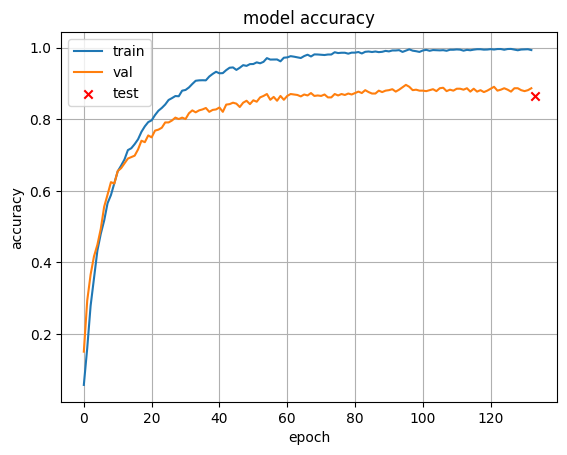

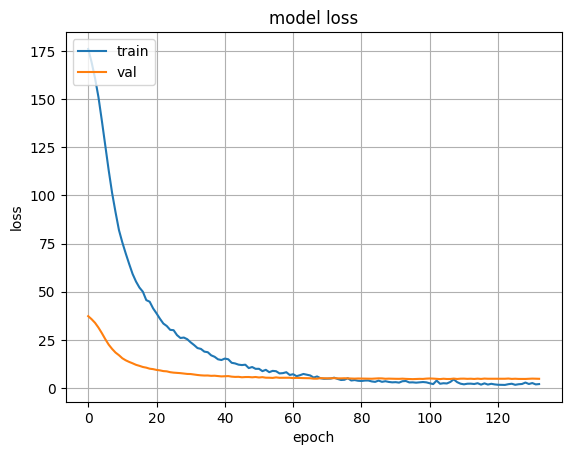

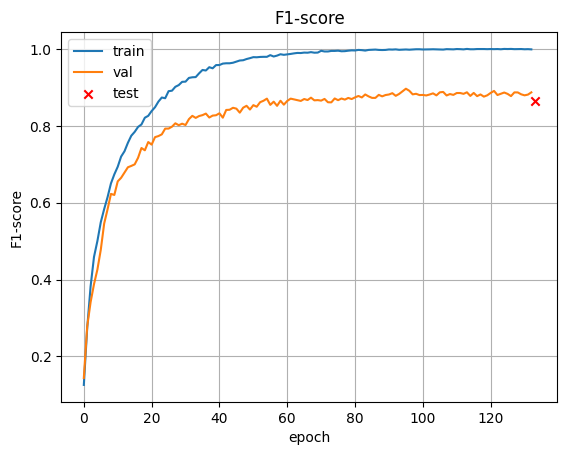


Fim
0.0578 0.1600 0.2787 0.3562 0.4330 0.4801 0.5170 0.5656 0.5884 0.6219 0.6548 0.6707 0.6880 0.7140 0.7192 0.7308 0.7444 0.7652 0.7805 0.7923 0.7972 0.8120 0.8241 0.8319 0.8414 0.8541 0.8593 0.8651 0.8645 0.8801 0.8821 0.8891 0.8989 0.9079 0.9090 0.9093 0.9090 0.9197 0.9269 0.9330 0.9287 0.9292 0.9376 0.9443 0.9451 0.9382 0.9443 0.9515 0.9495 0.9544 0.9547 0.9593 0.9567 0.9607 0.9711 0.9671 0.9674 0.9674 0.9622 0.9723 0.9731 0.9766 0.9752 0.9731 0.9714 0.9769 0.9806 0.9757 0.9815 0.9812 0.9804 0.9798 0.9812 0.9812 0.9876 0.9853 0.9861 0.9861 0.9835 0.9864 0.9864 0.9882 0.9841 0.9887 0.9896 0.9882 0.9896 0.9879 0.9887 0.9913 0.9899 0.9925 0.9925 0.9934 0.9884 0.9919 0.9957 0.9919 0.9905 0.9884 0.9925 0.9942 0.9916 0.9936 0.9931 0.9928 0.9934 0.9916 0.9945 0.9945 0.9954 0.9948 0.9919 0.9942 0.9931 0.9948 0.9960 0.9960 0.9948 0.9951 0.9962 0.9951 0.9965 0.9965 0.9945 0.9965 0.9968 0.9951 0.9931 0.9951 0.9957 0.9960 0.9936 
0.1507 0.2934 0.3661 0.4172 0.4495 0.4939 0.5559 0.5895 0.6245 

In [31]:
model = best_model # Atribuição para calculo de métricar posteriormente

test_report = get_classification_report(best_model, test_loader, class_names, device)
test_accuracy = test_report["accuracy"]
test_f1 = test_report["weighted avg"]["f1-score"]

test_epoch_index = len(train_accuracies)  # será o ponto após a última época

# Plot acurácia
plt.plot(train_accuracies)
plt.plot(val_accuracies)
plt.scatter(test_epoch_index, test_accuracy, color='red', marker='x', label="test")

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val', 'test'], loc='upper left')
plt.grid(True)
plt.show()

# Plot perda
plt.plot(train_losses)
plt.plot(val_losses)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid(True)
plt.show()

# Plot do f1
val_f1_scores = [rep["weighted avg"]["f1-score"] for rep in val_reports]
train_f1_scores = [rep["weighted avg"]["f1-score"] for rep in train_reports]
plt.plot(train_f1_scores)
plt.plot(val_f1_scores)
plt.scatter(test_epoch_index, test_f1, color='red', marker='x', label="test")
plt.title("F1-score")
plt.xlabel("epoch")
plt.ylabel("F1-score")
plt.legend(['train', 'val', 'test'], loc='upper left')
plt.grid(True)
plt.show()
print("\nFim")

print_metrics = True # Mude para printar ou não as métricas ao longo das épocas em forma de lista

if print_metrics:
    for x in train_accuracies:
        print(f"{x:.4f}", end=' ')
    print()
    for x in val_accuracies:
        print(f"{x:.4f}", end=' ')
    print() 
    print(test_accuracy)

    for x in train_losses:
        print(f"{x:.4f}", end=' ')
    print()
    for x in val_losses:
        print(f"{x:.4f}", end=' ')
    print() 

    for x in train_f1_scores:
        print(f"{x:.4f}", end=' ')
    print()
    for x in val_f1_scores:
        print(f"{x:.4f}", end=' ')
    print() 
    print(test_f1)

### Carregando modelo salvo 

In [11]:
if model_path != None:
    model = MobileNet_v2_Adapted()
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)

C:\Users\landrade\AppData\Local\Temp\ipykernel_12368\934461290.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=

## Gerando o espaço
Usa a rede para descrever todas as imagens do dataset como vetor para aplicarmos métodos de classificação em IA (o método de CNN não precisa disso)

In [15]:
def extract_features(model: nn.Module, input: torch.Tensor, device: torch.device) -> np.ndarray:
    """
    Extrai o vetor descritor (espaço latente) de um batch de imagens.

    Parâmetros:
        model: rede (com .features definido)
        input: tensor da imagem com shape [batch_size, 3, 224, 224]
        device: dispositivo (cuda ou cpu)

    Retorna:
        vetor descritor (np.ndarray) com shape [batch_size, 1280]
    """

    model.eval() # Modelo em modo de avaliação
    input = input.to(device) # Input movido pro device

    with torch.no_grad():
        x = model.features(input)
        x = x.mean(dim=[2, 3])
        x = torch.flatten(x, 1)
        return x.cpu().numpy()

In [ ]:
train_n_val_features = [] # Lista de vetores descritores
train_n_val_labels = [] # Lista de labels corretos

# Descrevendo o train set e o val set
for loader in [train_loader, val_loader]:
    for input, target in loader:
        train_n_val_features.extend(extract_features(model, input, device))
        train_n_val_labels.extend(target.cpu().numpy())

test_features = []
test_labels = []

# Descrevendo test set em uma lista separada
for input, target in test_loader:
    test_features.extend(extract_features(model, input, device))
    test_labels.extend(target.cpu().numpy())


## Solução com a CNN
Resultados da CNN (rode a célula de treino ou de carregar de arquivo antes)

### Sample and predict
Sorteia um dado do dataset de teste e mostra a classe prevista vs a classe real

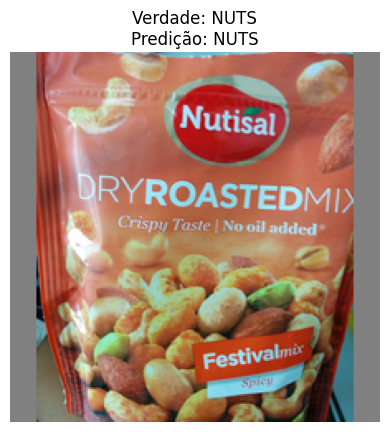

In [12]:
def denormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

def sample_and_predict(model: torch.nn.Module, dataset: ImageFolder, class_names: list[str], device: torch.device) -> None:
    model.eval()
    idx = random.randint(0, len(dataset) - 1)
    image, label = dataset[idx]

    input_tensor = image.unsqueeze(0).to(device)  # Adiciona dimensão de batch

      # Predição
    with torch.no_grad():
        output = model(input_tensor)
        pred_class = torch.argmax(output, dim=1).item()
  
    # Exibe resultado (com desnormalizacao)
    img_vis = denormalize(image.clone(), [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    plt.imshow(to_pil_image(img_vis))
    plt.title(f"Verdade: {class_names[label]}\nPredição: {class_names[pred_class]}")
    plt.axis("off")
    plt.show()
    
sample_and_predict(model, test_dataset, class_names, device)

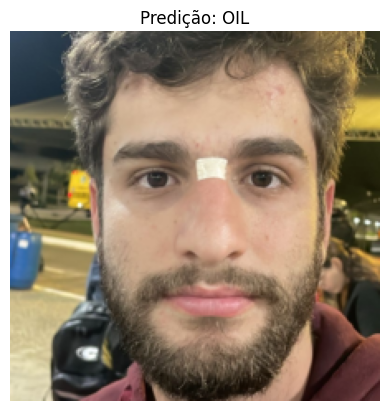

In [17]:
from random import randint

# Predict aplicado a fotos tiradas no mercado escola
def predict_image_from_path(model: torch.nn.Module, image_path: str, class_names: list[str], device: torch.device, transform: transforms.Compose):
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)
    model.eval()

    with torch.no_grad():
        outputs = model(image)
        predicted_idx = outputs.argmax(dim=1).item()
        predicted_label = class_names[predicted_idx]

    # Exibe resultado (com desnormalizacao)
    
    img_vis = denormalize(image.squeeze(0).cpu().clone(),
                          [0.485, 0.456, 0.406],
                          [0.229, 0.224, 0.225])
    plt.imshow(to_pil_image(img_vis))
    plt.title(f"Predição: {predicted_label}")
    plt.axis("off")
    plt.show()

idx = "fernando"

predict_image_from_path(model, f"escola\\{idx}.jpeg", class_names, device, test_transform)

### Métricas do modelo treinado

In [ ]:
test_report = get_classification_report(model, test_loader, class_names, device)
test_accuracy = test_report["accuracy"]
test_f1 = test_report["weighted avg"]["f1-score"]

print("Test Accuracy: %.2f%%" % (test_accuracy * 100))
print("Test f1 score: %.2f%%" % (test_f1 * 100))

print()

Test Accuracy: 89.76%
Test f1 score: 89.87%
{'BEANS': {'precision': 0.96, 'recall': 0.9230769230769231, 'f1-score': 0.9411764705882353, 'support': 26.0}, 'CAKE': {'precision': 0.9629629629629629, 'recall': 0.896551724137931, 'f1-score': 0.9285714285714286, 'support': 29.0}, 'CANDY': {'precision': 0.9245283018867925, 'recall': 0.9607843137254902, 'f1-score': 0.9423076923076923, 'support': 51.0}, 'CEREAL': {'precision': 0.9393939393939394, 'recall': 0.8611111111111112, 'f1-score': 0.8985507246376812, 'support': 36.0}, 'CHIPS': {'precision': 0.9333333333333333, 'recall': 0.9333333333333333, 'f1-score': 0.9333333333333333, 'support': 30.0}, 'CHOCOLATE': {'precision': 0.96, 'recall': 0.9056603773584906, 'f1-score': 0.9320388349514563, 'support': 53.0}, 'COFFEE': {'precision': 0.8888888888888888, 'recall': 0.8648648648648649, 'f1-score': 0.8767123287671232, 'support': 37.0}, 'CORN': {'precision': 0.9375, 'recall': 0.9375, 'f1-score': 0.9375, 'support': 16.0}, 'FISH': {'precision': 0.84210526

## Solução com KNN
Usa a CNN para vetorizar a imagem APENAS, mas classifica os vetores com KNN

### Hiper-parâmetros para o KNN

In [ ]:
k = 3 # Número de vizinhos 

### Treino e métricas do KNN

In [ ]:
# Treino do KNN
# Aplicar o SMOTE no treino
smote = SMOTE(random_state=42) # Técnica de oversampling que cria exemplos sintéticos para as classes que estão muito pequenas (tentar melhorar o desbalanceamento do dataset)
X_resampled, y_resampled = smote.fit_resample(train_n_val_features, train_n_val_labels)

knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_resampled, y_resampled)

pred_labels = knn.predict(test_features)

acc = accuracy_score(test_labels, pred_labels)
f1 = f1_score(test_labels, pred_labels, average='weighted')

print(f"Acurácia do KNN no conjunto de teste: {acc:.4f}")
print(f"F1-score do KNN no conjunto de teste: {f1:.4f}")
print("\nClassification Report:\n")
print(classification_report(test_labels, pred_labels, target_names=class_names))
fig, ax = plt.subplots(figsize=(12, 10))  # Aumente o tamanho conforme necessário
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
disp.plot(ax=ax, xticks_rotation=45)
plt.tight_layout()  # Evita sobreposição
plt.show()



Acurácia do KNN no conjunto de teste: 0.8881
F1-score do KNN no conjunto de teste: 0.8884

Classification Report:

              precision    recall  f1-score   support

       BEANS       0.96      0.96      0.96        26
        CAKE       0.96      0.93      0.95        29
       CANDY       0.80      0.94      0.86        51
      CEREAL       0.94      0.89      0.91        36
       CHIPS       1.00      0.93      0.97        30
   CHOCOLATE       0.98      0.87      0.92        53
      COFFEE       0.92      0.95      0.93        37
        CORN       1.00      1.00      1.00        16
        FISH       0.94      0.88      0.91        17
       FLOUR       0.82      0.90      0.86        10
       HONEY       0.97      0.91      0.94        34
         JAM       0.91      0.91      0.91        33
       JUICE       0.81      0.83      0.82        42
        MILK       0.91      0.80      0.85        25
        NUTS       0.96      0.81      0.88        27
         OIL       0

## Solução com Random Forest
Usa a CNN para vetorizar a imagem APENAS, mas classifica os vetores com Random Forest

### Hiper-parâmetros

In [ ]:
trees = 100 # Número de arvores de decisão 

### Treino e métricas

In [ ]:
# Treinar o modelo Random Forest
rf = RandomForestClassifier(n_estimators=trees, random_state=seed)
rf.fit(train_n_val_features, train_n_val_labels)

# Avaliar no conjunto de teste
predictions = rf.predict(test_features)
acc = accuracy_score(test_labels, predictions)

print(f"Acurácia com Random Forest: {acc * 100:.2f}%")
print("\nRelatório de classificação:")
print(classification_report(test_labels, predictions))

Acurácia com Random Forest: 88.81%

Relatório de classificação:
              precision    recall  f1-score   support

           0       0.96      0.88      0.92        26
           1       0.96      0.86      0.91        29
           2       0.86      0.96      0.91        51
           3       0.94      0.86      0.90        36
           4       0.97      0.93      0.95        30
           5       0.89      0.92      0.91        53
           6       0.90      0.97      0.94        37
           7       1.00      0.94      0.97        16
           8       0.94      0.88      0.91        17
           9       0.75      0.90      0.82        10
          10       0.94      0.91      0.93        34
          11       0.91      0.88      0.89        33
          12       0.85      0.83      0.84        42
          13       0.95      0.80      0.87        25
          14       0.95      0.78      0.86        27
          15       0.73      0.65      0.69        17
          16     

In [ ]:
# Célula com somote
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Separar treino e teste antes
X_train, X_test, y_train, y_test = train_test_split(features, labels, stratify=labels)

# Aplicar o SMOTE no treino
smote = SMOTE(random_state=42) # Técnica de oversampling que cria exemplos sintéticos para as classes que estão muito pequenas (tentar melhorar o desbalanceamento do dataset)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Treinar o modelo Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Avaliar no conjunto de teste
predictions = rf.predict(X_test)
acc = accuracy_score(y_test, predictions)
cm = confusion_matrix(y_test, predictions, labels=rf.classes_)

print(f"Acurácia com Random Forest: {acc * 100:.2f}%")
print("\nRelatório de classificação:")


fig, ax = plt.subplots(figsize=(12, 10))  # Aumente o tamanho conforme necessário
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
disp.plot(ax=ax, xticks_rotation=45)
plt.tight_layout()  # Evita sobreposição
plt.show()
print(classification_report(y_test, predictions))